In [ ]:
import pandas as pd
import warnings
import csv
from scipy.stats import boxcox
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

indicators = [
    "mask",
    "worried_catch_covid",
    "belief_masking_effective",
    "received_news_local_health",
    "received_news_experts",
    "received_news_who",
    "received_news_govt_health",
    "received_news_politicians",
    "received_news_journalists",
    "received_news_friends",
    "trust_covid_info_local_health",
    "trust_covid_info_experts",
    "trust_covid_info_who",
    "trust_covid_info_govt_health",
    "trust_covid_info_politicians",
    "trust_covid_info_journalists",
    "trust_covid_info_friends"
]

df = pd.read_csv('csv/usa_mondo.csv')  

sample_cols = [f'sample_size_{indicator}' for indicator in indicators]
columns_needed = ['country'] + sample_cols
df_filtered = df[columns_needed] #tengo solo colonne sample size
# calcola per ogni paese la media dei sample_size 
df_result = df_filtered.groupby('country').mean().reset_index()
print(df_result)


          country  sample_size_mask  sample_size_worried_catch_covid  \
0         Alabama       2161.613775                      1049.156295   
1          Alaska        433.044888                       213.580808   
2       Argentina       1515.275000                       733.585000   
3         Arizona       2961.974219                      1432.223336   
4        Arkansas       1504.276661                       732.589361   
..            ...               ...                              ...   
85        Vietnam       1290.000000                       617.042500   
86       Virginia       4105.411206                      1988.194922   
87     Washington       4027.317325                      1958.638898   
88  West Virginia       1191.579709                       588.134559   
89      Wisconsin       3027.666216                      1470.833850   

    sample_size_belief_masking_effective  \
0                            1052.900288   
1                             212.861619   
2  

In [ ]:
elenco_paesi = []
elenco_scarti = []
samplecolonne = [col for col in df_result.columns if col.startswith('sample_size_')] #salva dentro tutti i nomi delle colonne sample_... e non country
# Cicla riga per riga
for i in range(len(df_result)):    #paese i
    riga = df_result.iloc[i]
    paese = riga['country']
    mask = riga['sample_size_mask']
    
    # lista per raccogliere tutti gli scarti rispetto a sample_size_mask per il paese i
    scarti = []
    
    for colonna in samplecolonne:
        if colonna != 'sample_size_mask':
            x = riga[colonna]
            scarto = abs(x - mask)
            scarti.append(scarto)
    
    scarto_medio = np.mean(scarti) #faccio la media degli scarti

    elenco_paesi.append(paese)
    elenco_scarti.append(scarto_medio)

# Crea il DataFrame finale
df_finale = pd.DataFrame({
    'country': elenco_paesi,
    'scarto_medio': elenco_scarti
})

print(df_finale)

          country  scarto_medio
0         Alabama   1198.147803
1          Alaska    231.558480
2       Argentina    880.858906
3         Arizona   1627.883080
4        Arkansas    827.089903
..            ...           ...
85        Vietnam    780.263906
86       Virginia   2259.699073
87     Washington   2179.050202
88  West Virginia    644.435855
89      Wisconsin   1640.565329

[90 rows x 2 columns]


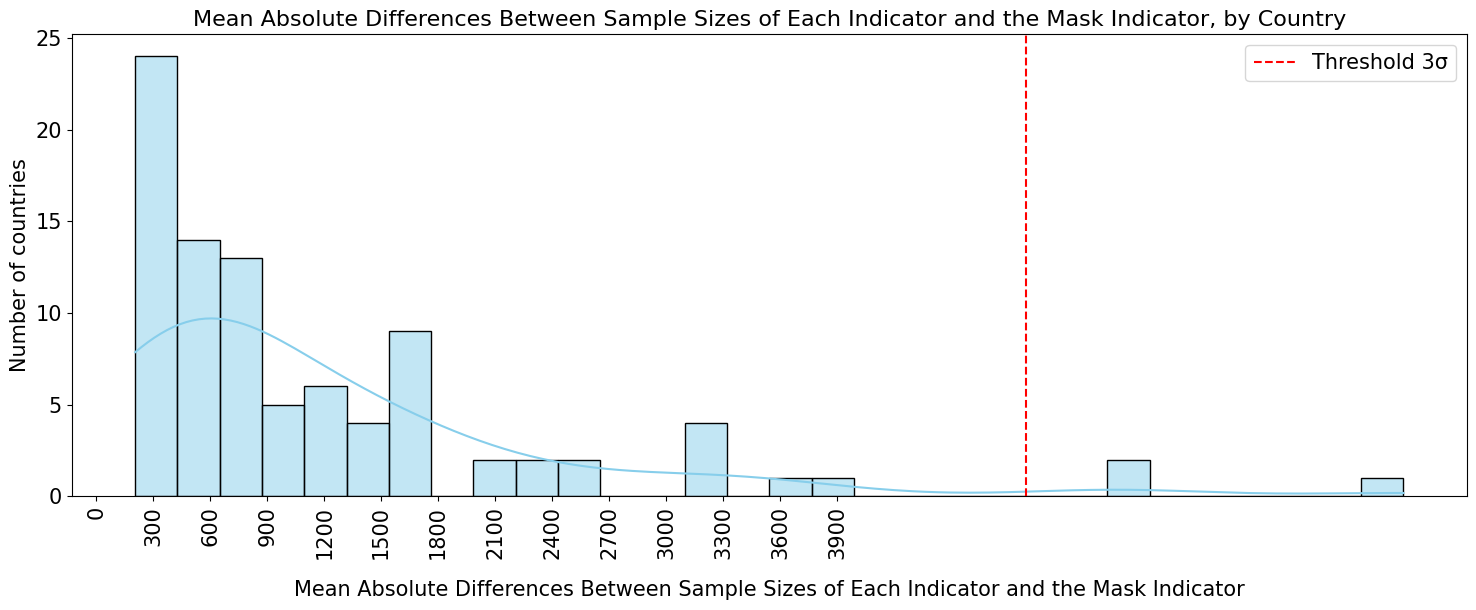

In [ ]:
#Calcolo soglia 3σ
media_scarti = df_finale['scarto_medio'].mean()
std_scarti = df_finale['scarto_medio'].std()
soglia1 = media_scarti + 3 * std_scarti

plt.figure(figsize=(18,6))
sns.histplot(df_finale['scarto_medio'], bins=30, kde=True, color='skyblue')
plt.title("Mean Absolute Differences Between Sample Sizes of Each Indicator and the Mask Indicator, by Country", fontsize=16)
plt.axvline(soglia1, color='red', linestyle='--', label='Threshold 3σ')
plt.xlabel("Mean Absolute Differences Between Sample Sizes of Each Indicator and the Mask Indicator", fontsize=15, labelpad=15)
plt.ylabel("Number of countries", fontsize=15)
plt.xticks(np.arange(0, 4001, 300), fontsize=15, rotation=90)
plt.yticks(fontsize=15,)
plt.legend( fontsize=15)
plt.show()

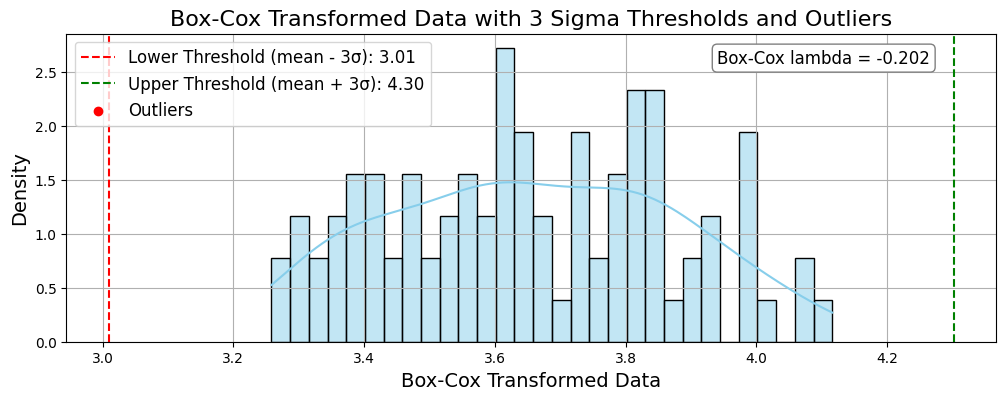

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from scipy.stats import skew

data_scarti = df_finale['scarto_medio']

if (data_scarti <= 0).any():
    data_scarti = data_scarti + abs(data_scarti.min()) + 1  # aggiungi un offset se ci sono valori zero o negativi

#trasformazione Box-Cox
transformed_data, best_lambda = boxcox(data_scarti)
mean_transformed = transformed_data.mean()
std_transformed = transformed_data.std()

# soglie
lower_threshold = mean_transformed - 3 * std_transformed
upper_threshold = mean_transformed + 3 * std_transformed

#------------------------------grafico
plt.figure(figsize=(12, 4))
sns.histplot(transformed_data, bins=30, kde=True, color='skyblue', stat='density')

# linee 3sigma
plt.axvline(lower_threshold, color='red', linestyle='--', label=f'Lower Threshold (mean - 3σ): {lower_threshold:.2f}')
plt.axvline(upper_threshold, color='green', linestyle='--', label=f'Upper Threshold (mean + 3σ): {upper_threshold:.2f}')

# outliers
outliers = transformed_data[(transformed_data < lower_threshold) | (transformed_data > upper_threshold)]
plt.scatter(outliers, np.zeros_like(outliers), color='red', label='Outliers', zorder=5)


plt.text(0.7, 0.95, f'Box-Cox lambda = {best_lambda:.3f}', ha='left', va='top', 
         transform=plt.gca().transAxes, fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='gray'))
plt.title("Box-Cox Transformed Data with 3 Sigma Thresholds and Outliers", fontsize=16)
plt.xlabel("Box-Cox Transformed Data", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
#plt.savefig(r'C:\Users\user\Desktop\immaginitt\boxcox.png', dpi=300, bbox_inches='tight')
plt.show()


Shapiro-Wilk Test: p-value = 0.0000
We reject the null hypothesis: the distribution is NOT normal.
Skewness: 2.28 (close to 0 = symmetrical distribution)
Kurtosis: 6.01 (close to 3 = normal tails)


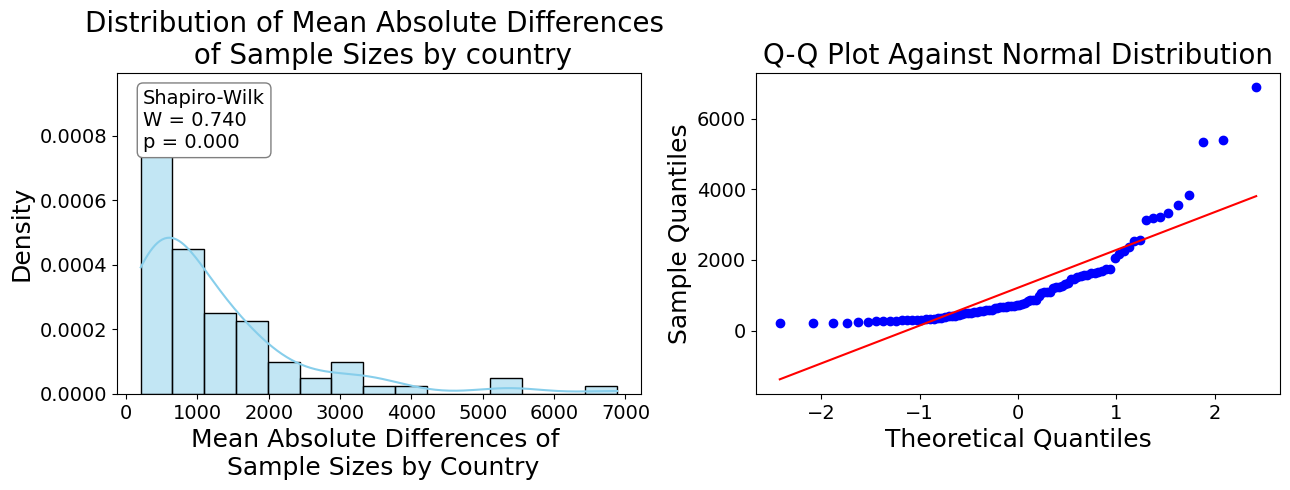

In [ ]:

from scipy import stats
from scipy.stats import skew, kurtosis

# Shapiro-Wilk Test - normalità
shapiro_stat, shapiro_p = stats.shapiro(df_finale['scarto_medio'])
print(f"Shapiro-Wilk Test: p-value = {shapiro_p:.4f}")
if shapiro_p > 0.05:
    print("We cannot reject the null hypothesis: the distribution is normal.")
else:
    print("We reject the null hypothesis: the distribution is NOT normal.")

# skewness and kurtosis
skewness = skew(df_finale['scarto_medio'])
kurt = kurtosis(df_finale['scarto_medio'])
print(f"Skewness: {skewness:.2f} (close to 0 = symmetrical distribution)")
print(f"Kurtosis: {kurt:.2f} (close to 3 = normal tails)")

# --------------------grafico
plt.figure(figsize=(13, 5))


plt.subplot(1, 2, 1)
sns.histplot(df_finale['scarto_medio'], kde=True, stat='density', bins=15, color='skyblue')
plt.title('Distribution of Mean Absolute Differences \n of Sample Sizes by country', fontsize=20)
plt.xlabel('Mean Absolute Differences of \n Sample Sizes by Country', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.annotate(
    f'Shapiro-Wilk\nW = {shapiro_stat:.3f}\np = {shapiro_p:.3f}',
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    ha='left',
    va='top',
    fontsize=14,
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray')
)

plt.subplot(1, 2, 2)
stats.probplot(df_finale['scarto_medio'], dist='norm', plot=plt)
plt.title('Q-Q Plot Against Normal Distribution', fontsize=20)
plt.xlabel('Theoretical Quantiles', fontsize=18)
plt.ylabel('Sample Quantiles', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
plt.savefig(r'C:\Users\user\Desktop\immaginitt\qqsamplesize.png', dpi=300, bbox_inches='tight')
plt.show()






In [ ]:
#  paesi con scarto_medio maggiore di soglia
paesi_outlier = df_finale[(transformed_data > upper_threshold)  | (transformed_data< lower_threshold)]
print(paesi_outlier['country'])
paesi_rimanenti = df_finale[~df_finale['country'].isin(paesi_outlier['country'])]

# salva in CSV solo la colonna 'country'
paesi_rimanenti[['country']].to_csv("csv/scartomedio_countries.csv", index=False)

Series([], Name: country, dtype: object)


In [ ]:
#elimino sample size colonne da FULL_DATA
df = pd.read_csv('csv/usa_mondo.csv')  

sample_cols = [f'pct_{indicator}' for indicator in indicators]
columns_needed = ['country'] + ['survey_date'] +sample_cols 
df_fil = df[columns_needed]
full_data = df_fil[~df_fil["country"].isin(paesi_outlier['country'])]
full_data.to_csv("csv/FULL_DATA2.csv", index=False)